In [283]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# General Utilities
import math
import json
import pprint
import itertools
import importlib
import itertools 
from itertools import zip_longest
import numpy as np
from scipy import stats
from scipy import special as fn
import collections, itertools
from operator import itemgetter as at
from random import randint
import random
import math
from matplotlib.gridspec import GridSpec
from stochastic.processes.continuous import GammaProcess

# Some settings
from IPython.display import Markdown, display
log = pprint.pprint
space = lambda: print()
printmd = lambda text: display(Markdown(text))
%matplotlib inline

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    display = pd.options.display
    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000

set_pandas_display_options()

#g compute completion time using gamma
def compute_time(completion, time, beta_0, alpha_0, alpha, expected_beta, rho):    
    #compute the times iteratively
    expected_times = np.array([])
    for i,_ in enumerate(completion):        
        expected_beta = (alpha_0 + alpha*(time[i]-time[0]))/(beta_0 + (completion[i]-completion[0])) 
        expected_time = ((rho*expected_beta)/alpha)+(1/(2*alpha)) #compute expected time        
        expected_times = np.append(expected_times, expected_time)
    return expected_times

In [284]:
non_insight = ['Eric is trying to get in shape. He wants to do this by climbing stairs. He starts on the third floor, climbs up five stories, down seven, up six, down three, up four, down four, up five, down three, and then up two again. What floor is he on now?',
'Ben spent $42 for shoes. This was $14 less than what he spent for a shirt and twice more expensive than the tie. The tie was $20 cheaper than the jeans. How much was the jeans?',
'Andrew is twice the age of Brian, Charles is three times older than Brian, and the sum of their ages is 60 years. How old is Charles?',
'Erin had 24 marbles and Evan had 3 marbles. Erin gave some of her marbles to Evan. Now Erin has exactly double the number of marbles that Evan has. How many marbles did Erin give to Evan?',
'Lebrun, Lenoir, and Leblanc are, not necessarily in that order, the accountant, warehouseman, and traveling salesman of a firm. The salesman is unmarried. Both Lebrun and Lenoir are married. Lebrun is not the accountant. What job does Lenoir have? Accountant, warehouseman, or salesman?'];
anagram = ['Solve this anagram: EURADBL', 
						'Solve this anagram: MATCILE', 
						'Solve this anagram: AYKAWLJ',
						'Solve this anagram: LUBMEJD',
						'Solve this anagram: NITGA',]

#take mean increment after excluding the max increment
def return_mean_after_excludeMax(list1):
    lst_sort = [sorted(item) for item in list1]
    for sublist in lst_sort:
        del sublist[-1] #delete the max increment from each list
    
    listofmeans = [np.mean(i) for i in lst_sort] #get mean increment for each list
    return listofmeans

In [285]:
with open('main.json') as json_file:
    data = json.load(json_file)  

In [286]:
questions_non_insight = []
answers_non_insight = [] #whether people typed done or skip
solutions_non_insight = []
difficulty_non_insight = []
aha_non_insight = []
rts_non_insight = []
close_non_insight = []

questions_anagram = []
solutions_anagram = []
answers_anagram = []
difficulty_anagram = []
aha_anagram = []
rts_anagram = []
close_anagram = []

num_subs = 0
for i in range(len(data)): #go thru the subjects
    if len(data[i]['data']) > 3: #only look at subjects that finished the task             
            num_subs = num_subs+1
            k = 4
            
            for j in range(2):
                question = data[i]['data'][0]['problems_seen'][j] #store the question seen by the participant
                answers = []
                rt = 0     
                bad_subject = 0
                close = []
                
                while True:
                    answer = data[i]['data'][k]['responses']
                    answers.append(answer)
                    click = int(data[i]['data'][k]['rt']) #only finish if person typed a response and clicked continue
                    k = k+1
                    close.append(int(data[i]['data'][k]['response']))
                    
                    if (len(answer) > 9 and click < 10000):
                        rt = rt + data[i]['data'][k]['rt']/1000
                        k = k+1
                        break
                    else:
                        rt = rt+10
                        k = k+1
                        
                       
                solution = answer #store people's solution here
                response = data[i]['data'][k]['responses'] #store people's responses to the judgment questions here
                
                k = k+2 #move to the next question
                
                if question in non_insight:   
                    questions_non_insight.append(question)
                    answers_non_insight.append(answers)
                    solutions_non_insight.append(solution)
                    rts_non_insight.append(rt)
                    difficulty_non_insight.append(int(response[6])+1)
                    aha_non_insight.append(int(response[13])+1)
                    close_non_insight.append(close)

                elif question in anagram:
                    questions_anagram.append(question)
                    answers_anagram.append(answers)
                    solutions_anagram.append(solution)
                    rts_anagram.append(rt)
                    difficulty_anagram.append(int(response[6])+1)
                    aha_anagram.append(int(response[13])+1)
                    close_anagram.append(close)

print('we recruited ', num_subs, 'subjects')

we recruited  502 subjects


Convert data into df

In [287]:
d = {'questions':questions_non_insight,
     'answers':answers_non_insight, 
     'solutions': solutions_non_insight,
     'rts': rts_non_insight,
     'difficulty': difficulty_non_insight, 
     'aha': aha_non_insight,
     'close': close_non_insight}

d2 = {'questions':questions_anagram,
     'answers':answers_anagram, 
      'solutions': solutions_anagram,
     'rts': rts_anagram,
     'difficulty': difficulty_anagram, 
     'aha': aha_anagram,
     'close': close_anagram}

df_non_insight = pd.DataFrame(d)
df_anagram = pd.DataFrame(d2)

Filter the data based on some criteria

In [345]:
#correct answers to the problems
solutions1 = 'Accountant|41|eighth|8|8th|eight|30|thirty|six|6|account|warehouse|9|36|11|4|warehouseman|34|18'
#
solutions2 = 'durable|giant|jaywalk|climate|jumbled'

#analyze only those responses for which people's answer is correct
df_non_insight_filtered = df_non_insight.loc[(df_non_insight['solutions'].str.contains(solutions1, case = False)==True)
                                             #& (df_non_insight['close'].str[0] != 100) 
                                             #& (df_non_insight['close'].str.len() > 1)
                                             & (df_non_insight['close'].str[-1] > 80)
                                            ]

df_anagram_filtered = df_anagram.loc[(df_anagram['solutions'].str.contains(solutions2, case = False)==True) 
                                      #&(df_anagram['close'].str[0] != 100) 
                                      #&(df_anagram['close'].str.len() > 1)
                                      #&(df_anagram['close'].str[-1] > 80)
                                    ]

print(len(df_non_insight.index), len(df_non_insight_filtered.index))
print(len(df_anagram.index), len(df_anagram_filtered.index))

502 313
502 331


In [346]:
df1 = df_non_insight.groupby(['questions'], as_index=False).agg(['mean', 'count'])
df2 = df_non_insight_filtered.groupby(['questions'], as_index=False).agg(['mean', 'count'])
#print(df2.index)
#print('% Solved')
#print(df2['rts']['count'].values/df1['rts']['count'].values)
#print('Solved count')
#print(df2['rts']['count'].values)
#print('Mean difficulty')
#print(df2['difficulty']['mean'].values)
print('Mean RT')
print(df2['rts']['mean'].values)
print('Mean Aha')
print(df2['aha']['mean'].values)

Mean RT
[52.90615821 45.41597321 45.29910735 49.58896226 67.68044167]
Mean Aha
[3.85074627 3.10714286 2.67647059 3.88709677 3.78333333]


In [347]:
df3 = df_anagram.groupby(['questions'], as_index=False).agg(['mean', 'count'])
df4 = df_anagram_filtered.groupby(['questions'], as_index=False).agg(['mean', 'count'])
#print(df3.index)
#print('% Solved')
#print(df4['rts']['count'].values/df3['rts']['count'].values)
#print('Solved count')
#print(df4['rts']['count'].values)
#print('Mean difficulty')
#print(df4['difficulty']['mean'].values)
print('Mean RT')
print(df4['rts']['mean'].values)
print('Mean Aha')
print(df4['aha']['mean'].values)
print(np.mean(df_non_insight_filtered['aha'].values))

Mean RT
[43.80846613 22.51905278 19.73450921 30.21474021 26.34956667]
Mean Aha
[5.17741935 5.29166667 5.30487805 5.35714286 5.17777778]
3.4568690095846644


/Users/rachitdubey/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


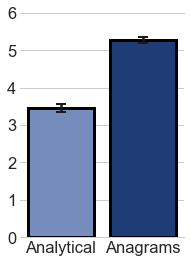

In [348]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(3,4), 
                                              "grid.linewidth": 1, "axes.linewidth": 1, 'patch.linewidth': 3.0})

color = ['#6B88C7','#103783']
ax = sns.barplot(np.arange(2), [np.mean(df_non_insight_filtered['aha'].values), np.mean(df_anagram_filtered['aha'].values)]
                 , yerr=[np.std(df_non_insight_filtered['aha'].values)/np.sqrt(len(df_non_insight_filtered['aha'].values)), 
                        np.std(df_anagram_filtered['aha'].values)/np.sqrt(len(df_anagram_filtered['aha'].values))], 
                 palette = color, edgecolor = 'black',error_kw=dict(ecolor='k', lw=2.5, capsize=5, capthick=2))
plt.xticks(np.arange(2), ['Analytical', 'Anagrams'])
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim([0,6])
plt.tight_layout()
sns.despine(ax=ax, left=True, top=False)
plt.savefig('aha.png',dpi=1200)

#plt.title('Mean Aha! ratings')

Truncate data -- only gather closeness ratings until the first time subjects enter the correct answer (sometimes they aren't able to press enter..)

In [349]:
a = df_non_insight_filtered['answers'].values
truncate_insight = []
c1 = 0
for j in range(len(a)):
    for k in range(len(a[j])):
        a1 = pd.Series(a[j][k])
        if a1.str.contains(solutions1, case = False).bool() == True:
                truncate_insight.append(k)
                if k < len(a[j])-1:
                    c1 = c1+len(a[j])-k
                break
                
a = df_anagram_filtered['answers'].values
truncate_anagram = []
c2 = 0
for j in range(len(a)):
    for k in range(len(a[j])):
        a1 = pd.Series(a[j][k])
        if a1.str.contains(solutions2, case = False).bool() == True:
                truncate_anagram.append(k)
                if k < len(a[j])-1:
                    c2 = c2+len(a[j])-k
                break
#pretty sure truncate_insight and truncate_anagrams are correct. 
print(c1,c2)

184 130


For the filtered data, get average increment (until the timepoint of max increment) and max increment

4.852024443816945 8.179257362355953 781
0.1258076223621736 2.395770392749245 331


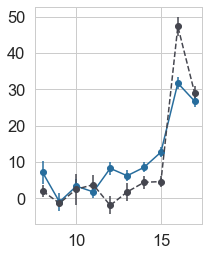

In [350]:
increment_non_insight = []
close_non_insight = []
for i in range(len(df_non_insight_filtered.index)):
    a = df_non_insight_filtered['close'].iloc[i]
    b = a[0:truncate_insight[i]+1] #don't include repeat
    increment_non_insight.append(np.diff(b))
    close_non_insight.append(b)

n = 10
a = increment_non_insight
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_2 = pd.DataFrame(l)
y = np.flip(df_2.mean(0).values)
x = np.array(range(len(y)))+1
e = np.flip(df_2.sem(0,ddof=0).values)
c = np.flip(df_2.count(0).values)
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='-', marker='o', color = '#276d9d')

df3 = df_2.drop([0, 1], axis=1)
print(np.mean(df3.mean()), np.mean(df3.stack().mean()),len(df3.stack()))  

increment_anagram = []
close_anagram = []
for i in range(len(df_anagram_filtered.index)):
    a = df_anagram_filtered['close'].iloc[i]
    b = a[0:truncate_anagram[i]+1] #don't include repeat
    increment_anagram.append(np.diff(b))
    close_anagram.append(b)

a = increment_anagram
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)
plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = '#45464f')

df2 = df_1.drop([0, 1], axis=1)
print(np.mean(df2.mean()), np.mean(df2.stack().mean()), len(df2.stack())) 

3.4568690095846644 5.27190332326284 1.7455262136084428 1.5925892396101031


/Users/rachitdubey/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rachitdubey/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rachitdubey/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

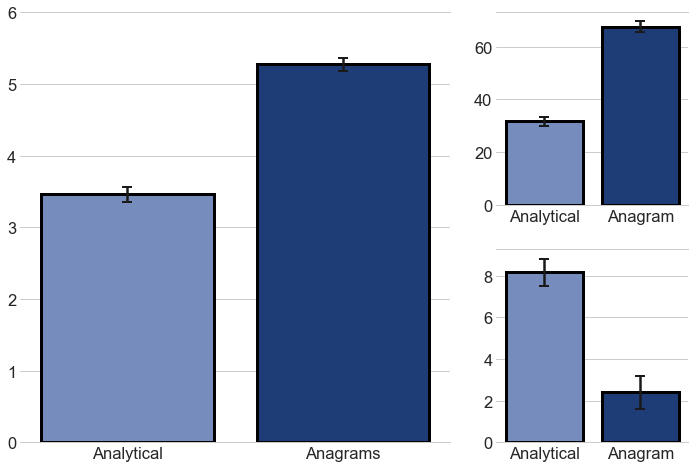

Ttest_indResult(statistic=-13.774684259113437, pvalue=5.236833714326986e-38)
Ttest_indResult(statistic=-13.408743002136331, pvalue=1.3627488513947738e-35)
Ttest_indResult(statistic=5.180651316429667, pvalue=2.624641234143277e-07)
(0.2201584703667261, 2.2510948802629053e-07) 644


In [384]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.5, rc={"grid.linewidth": 1, "axes.linewidth": 1, 'patch.linewidth': 3.0})
color = ['#6B88C7', '#103783']
#color = ['#B6CCFE', '#00257A']

import matplotlib.gridspec as gridspec
fig = plt.figure(1)
gridspec.GridSpec(2,3)

print(np.mean(df_non_insight_filtered['aha'].values), np.mean(df_anagram_filtered['aha'].values), np.std(df_non_insight_filtered['aha'].values), np.std(df_anagram_filtered['aha'].values))
plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
ax = sns.barplot(np.arange(2), [np.mean(df_non_insight_filtered['aha'].values), np.mean(df_anagram_filtered['aha'].values)]
                 , yerr=[np.std(df_non_insight_filtered['aha'].values)/np.sqrt(len(df_non_insight_filtered['aha'].values)), 
                        np.std(df_anagram_filtered['aha'].values)/np.sqrt(len(df_anagram_filtered['aha'].values))], 
                 palette = color, edgecolor = 'black',error_kw=dict(ecolor='k', lw=2.5, capsize=5, capthick=2))
plt.xticks(np.arange(2), ['Analytical', 'Anagrams'])
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.ylim([0,6])
sns.despine(ax=ax, left=True, top=False)

plt.subplot2grid((2,3), (0,2))
ax = sns.barplot(np.arange(2), [df_2[1].mean(), df_1[1].mean()]
                 , yerr=[df_2[1].sem(), df_1[1].sem()], 
                 palette = color, edgecolor = 'black', error_kw=dict(ecolor='k', lw=2.5, capsize=5, capthick=2))
plt.xticks(np.arange(2), ['Analytical','Anagram'])
ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.title('Max increment')
sns.despine(ax=ax, left=True, top=False)

plt.subplot2grid((2,3), (1,2))
ax = sns.barplot(np.arange(2), [df3.stack().mean(), df2.stack().mean()]
                 , yerr=[df3.stack().sem(), df2.stack().sem()], 
                 palette = color, edgecolor = 'black', error_kw=dict(ecolor='k', lw=2.5, capsize=5, capthick=2))
plt.xticks(np.arange(2), ['Analytical','Anagram'])
ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.title('Mean increment')
#plt.ylim([0,10])
sns.despine(ax=ax, left=True, top=False)

fig.tight_layout()
fig.set_size_inches(w=10,h=7)
#plt.savefig('aha+max+mean.png',dpi=1200)
plt.show()

#stats
from scipy import stats
print(stats.ttest_ind(df_non_insight_filtered['aha'].values, df_anagram_filtered['aha'].values))
a = df_2[df_2[1].notna()][1]
b = df_1[df_1[1].notna()][1]
print(stats.ttest_ind(a, b))
print(stats.ttest_ind(df3.stack(), df2.stack()))

ahas = np.concatenate([df_non_insight_filtered['aha'].values, df_anagram_filtered['aha'].values])
maxes = np.concatenate([df_2[1], df_1[1]])
c = np.vstack([ahas,maxes])
d = c[:,~np.any(np.isnan(c), axis=0)] #g remove nans
print(stats.mstats.pearsonr(d[0],d[1]), len(ahas))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 3.          3.          3.         13.33333333 11.8        15.4
 16.         12.92857143 16.35       12.36363636 13.22222222 11.96428571
 17.712      20.48587571 25.54958678 36.5472973  67.39297125 94.08626198]
[0.         0.         2.12132034 8.92354356 6.73735853 6.21642984
 5.30848378 4.32182913 4.8302562  3.13773742 2.49177889 1.79319437
 1.82093834 1.6873486  1.57144313 1.63650036 1.69072282 0.65631955]
counts: [  1   1   2   3   5  10  10  14  20  33  54  84 125 177 242 296 313 313]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 2.          6.          6.          7.          6.         10.
  9.          9.         27.5        22.5        18.         35.
 22.5        17.         14.         21.         14.          8.4
 10.         13.83333333  7.8         8.90909091  7.375       8.89473684
 15.10714286 10.35555556 12.78461538 15.54255319 19.36423841 67.43089431
 96.90936556]
[ 0.          0.          0.       

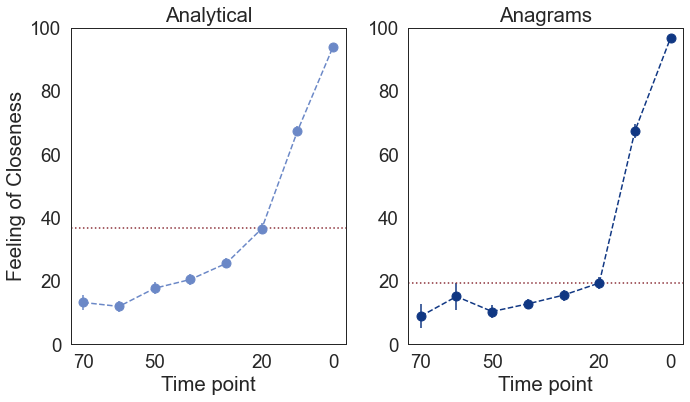

In [373]:
import seaborn as sns
sns.set(style="white", font_scale=1.7, rc={'figure.figsize':(10,6), 
                                              "grid.linewidth": 1, "axes.linewidth": 1,})

a = close_non_insight
n = 8 #how many points
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
non_insight_data = l
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)
print(x)
print(y)
print(e)
print('counts: '+str(c))
last_ratings_non_insight = df_1[0].values

x = np.array(range(len(y)))+1
plt.subplot(1, 2, 1)
ax = plt.gca()
ynew = 36.6
ax.axhline(ynew, color='#8A2E37', linewidth=1.5, linestyle=':')


plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = '#6B88C7', markersize=9)
plt.xticks(x[-n:], ['70', '', '50', '','','20','','0'])
plt.ylim([0,100])
plt.title('Analytical')
plt.ylabel('Feeling of Closeness')
plt.xlabel('Time point')

a = close_anagram
m = [li[::-1] for li in a]
l = [np.array(xi) for xi in m]
anagram_data = l
df_1 = pd.DataFrame(l)
y = np.flip(df_1.mean(0).values)
e = np.flip(df_1.sem(0,ddof=0).values)
c = np.flip(df_1.count(0).values)

last_ratings_anagram = df_1[0].values

#x = np.array(range(len(y)))+1
plt.subplot(1, 2, 2)
ax = plt.gca()
ynew = 19.5
ax.axhline(ynew, color='#8A2E37', linewidth=1.5, linestyle=':')

plt.errorbar(x[-n:], y[-n:], e[-n:], linestyle='--', marker='o', color = '#103783', markersize=9)
plt.xticks(x[-n:], ['70', '', '50', '','','20','','0'])
plt.ylim([0,100])
plt.title('Anagrams')
plt.xlabel('Time point')

#ax.grid(which='major', axis='y', linestyle='--')
print(x)
#print(y[-1], e[-1])
print(y)
print(e)
print('counts: '+str(c))

plt.tight_layout()

#plt.savefig('meta_rate.png',dpi=1200)
#plt.show()



In [120]:
from scipy import stats
stats.ttest_ind(last_ratings_anagram, last_ratings_non_insight)
#print(np.mean(last_ratings_non_insight), np.mean(last_ratings_anagram))

Ttest_indResult(statistic=6.917935075541374, pvalue=1.0379300590356301e-11)

Gamma process simulation -- individual fit depends on the prior; normaliziation probably makes sense? 



In [301]:
alpha = 25 #Prior agent
alpha_0 = 25
beta_0 = 25
expected_beta = beta_0
rho = 100
ahas1 = []

for a in non_insight_data:
    b = np.flip(a) #flip array
    completion = np.maximum.accumulate(b) #make data monotonic
    time = np.arange(len(b))
    expected_times = compute_time(completion, time, beta_0,alpha_0, alpha, expected_beta, rho)
    expected_times = np.append(expected_times, (len(b))) #g add 
    expected_times = np.delete(expected_times, 0)
    
    r = 100
    expected_r = r-expected_times
    aha1 = np.ediff1d(expected_r)
    #print(completion, expected_times, aha1, max(aha1))    
    f = max(aha1)
    if f > 10:
        f = 10
    elif f < 0:
        f = 0
    else:
        f = round(max(aha1),3)
    ahas1.append(f)

ahas2 = []
for a in anagram_data:
    if len(a) > 1: #can't analyze data for which there is just 1 data point
        b = np.flip(a) #flip array
        completion = np.maximum.accumulate(b) #make data monotonic
        time = np.arange(len(b))
        expected_times = compute_time(completion, time, beta_0,alpha_0, alpha, expected_beta, rho)
        expected_times = np.append(expected_times, (len(b))) #append final completion point
        expected_times = np.delete(expected_times, 0) #remove first point (which is just prior) 
        
        r = 100
        expected_r = r-expected_times
        aha2 = np.ediff1d(expected_r)
        #print(completion, expected_times, aha2, max(aha2))
        f = max(aha2)
        if f > 10:
            f = 10
        elif f < 0:
            f = 0
        else:
            f = round(max(aha2),3)
        ahas2.append(f)

print(np.mean(ahas1),np.std(ahas1),len(ahas1), np.mean(ahas2), np.std(ahas2), len(ahas2))
stats.ttest_ind(ahas1, ahas2)

6.151444089456869 3.993170424913163 313 6.205780487804877 4.272539257620924 246


Ttest_indResult(statistic=-0.1545655689362508, pvalue=0.8772198049050342)

Mixed model analysis

In [298]:
subj = np.concatenate((df_non_insight_filtered['aha'].values, df_anagram_filtered['aha'].values))
model = np.concatenate((ahas1,ahas2))
from scipy.stats.stats import pearsonr
pearsonr(subj,model)

ValueError: x and y must have the same length.

Create separate dfs for each non insight question

In [57]:
ahas2

[5.0,
 5.0,
 2.0,
 2.0,
 1.0,
 2.0,
 7,
 2.0,
 1.0,
 6.0,
 2.0,
 6.0,
 7,
 2.0,
 2.0,
 6.0,
 4.0,
 7,
 2.0,
 5.0,
 6.0,
 4.0,
 4.0,
 1.0,
 1.0,
 5.0,
 4.0,
 6.0,
 6.0,
 2.0,
 6.0,
 2.0,
 1,
 6.0,
 1.0,
 6.0,
 7,
 7,
 2.0,
 4.0,
 6.0,
 1.0,
 3.0,
 6.0,
 7,
 5.0,
 6.0,
 2.0,
 4.0,
 7.0,
 3.0,
 7.0,
 2.0,
 5.0,
 1.0,
 6.0,
 2.0,
 4.0,
 7,
 7,
 1.0,
 3.0,
 6.0,
 6.0,
 2.0,
 7,
 3.0,
 5.0,
 2.0,
 7,
 2.0,
 1,
 6.0,
 2.0,
 4.0,
 4.0,
 6.0,
 6.0,
 2.0,
 7,
 2.0,
 6.0,
 4.0,
 2.0,
 2.0,
 6.0,
 4.0,
 6.0,
 7,
 4.0,
 2.0,
 2.0,
 2.0,
 7,
 2.0,
 2.0,
 2.0,
 6.0,
 7,
 2.0,
 2.0,
 2.0,
 6.0,
 2.0,
 7,
 2.0,
 6.0,
 6.0,
 6.0,
 4.0,
 4.0,
 5.0,
 6.0,
 1.0,
 6.0,
 7,
 2.0,
 7,
 6.0,
 2.0,
 4.0,
 2.0,
 6.0,
 1.0,
 6.0,
 5.0,
 4.0,
 5.0,
 4.0,
 6.0,
 2.0,
 1.0,
 5.0,
 7,
 2.0,
 7,
 5.0,
 7,
 3.0,
 6.0,
 4.0,
 2.0,
 2.0,
 7,
 6.0,
 3.0,
 2.0,
 2.0,
 2.0,
 7,
 4.0,
 7,
 4.0,
 5.0,
 6.0,
 4.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 6.0,
 5.0,
 4.0,
 6.0,
 1.0,
 1.0,
 1,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 7

Mean progress for non-insight vs. anagram problems